_get elongation rate and  fresh elongation rate after division_
1. Calculate elongation rate from linear fitting on the log plot
2. Calculate fresh elongation rate from linear fitting of first 5 points (10min) after division #TODO: extend to 8?
3. Sanity check: plot cell length to real time with fitting, each image with 5 plots.
_Note:_ csv in this form can easily read also by excel and make quick analysis.

----20250310 revise---
Input from '-tracks-cv2.csv', 
 ["cell_ID", "cell_parent_ID", "cell_daughter1_ID", "cell_daughter2_ID", "lineage", "generation", "tm_spot_ID", "frame", 
 "x", "y", "area", "solidity", "rect_length", "rect_aspect_ratio", "rect_angle", "ellipse_long_axis", "ellipse_theta"]
 
 Output '-elg-cv2.csv'
[cell_ID,generation,time_start,mean_solidity,Lb,Ld,elgRate_b,elgRate_start_b,elgRate_e,elgRate_start_e,division_time]
----20250311----
Calculate realtime elongation rate "-tracks-cv2-elgrt.csv" # still need revision, results kept in 2ndAna

---20250330---
add Sanity check: print cell tracks whose elgRate is out of 3 sigma


241029 add elongation realtime 
* trajDic to elgDic, at each point calculate elongation from [-2, 2] frames, 10min, 5 frames
250303 combine with growth_elongation
250306 read in traj from '-track.csv' as DataFrame
250310 '-tracks-cv2.csv'

In [2]:
# import the essential packages 
import numpy as np   # for numerics
import glob   #for parsing directories and files
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt  #for plotting
import random
import cv2
import os
from matplotlib import cm
import json
import pickle
import pandas as pd

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

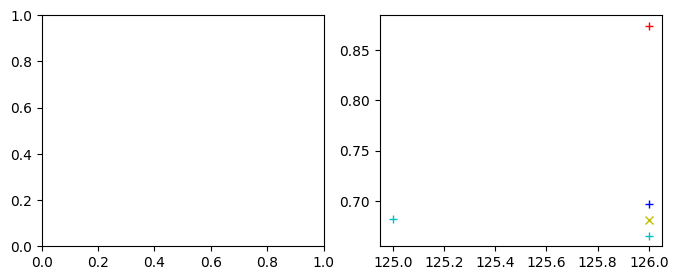

In [2]:
"""
# for series data 075-600
Single elongation rate calculation from bounding box 
Add date="_250628" to all the datafiles and plots
For data used for manuscript, after manual correction

1. elgRate_b: elongation rate of each cell, fit bounding box length from division to division, 
    use track length > 4, cell mean_solidity>0.7
2. time_start: time at birth, (time at 1st frame if "cell_parent_ID" not Null)
3. Lb: length right after division (length at 1st frame if "cell_parent_ID" not Null) 
    if solidity>0.7, calculate from area and mean_width
4. Ld: length at last frame if "cell_daughter1_ID" not Null, 
    if solidity>0.7, calculate from area and mean_width
5. division_time**: time span of the track is both "cell_parent_ID" and "cell_daughter1_ID" not Null
6. Test calculation for cell width with plot, width calculated irregardless of solidity


Input: Tracks DataFrame '-tracks-cv2.csv'
 ["cell_ID", "cell_parent_ID", "cell_daughter1_ID", "cell_daughter2_ID", "lineage", "generation", "tm_spot_ID", "frame", 
 "x", "y", "area", "solidity", "rect_length", "rect_aspect_ratio", "rect_angle", "ellipse_long_axis", "ellipse_theta"]

Output: 
 [cell_ID, generation, time_start, mean_solidity, mean_width, Lb, Ld, elgRate_b, division_time]
"""

import scipy.optimize
from scipy.optimize import curve_fit

def ef(t, x0, k):
    return x0*np.exp(k*t)

def ef_e(t, x0_e, k):
    return x0_e + k*t

def compute_width_from_area_length(A, l):
    alpha = 1 - np.pi / 4  # ≈ 0.2146
    discriminant = l**2 - 4 * alpha * A
    if discriminant < 0:
        return np.nan  # or raise warning
    w = (l - np.sqrt(discriminant)) / (2 * alpha)
    return w

def compute_length_from_area_width(A, w):
    if w is None or np.isnan(w):
        return np.nan
    else:
        alpha = 1 - np.pi / 4  # ≈ 0.2146
        return (A + alpha * w**2) / w
       
scale60 = 0.1078 # old 0.1083  # um per pixel
# scale100 = 0.065 # old scale 
scale100 = 0.0639  # new scale ab 2405
minpf = 2  # min per frame, 0.5 or 2
date="_250628"

pathDict = {'075': ['241219-075-ana/00738', 
                    '250116-075-ana/00814', 
                    '250117-075-2-ana/00823'],
            '150': ['240228-150-1-ana/00324',
                   '250107-150-ana/00778', 
                   '250108-150-ana/00788',
                   '250606-150-ana/00909'],
            '300': ['241220-3-ana/00753', 
                   '250102-3-ana/00766',
                   '250103-3-2-ana/00772-2'],
            '600': ['241218-6-ana/00734-2',
                   '250115-6-1-ana/00798-2']
}

pathDict0 = {'150': ['250107-150-1-ana/00778']}

c='150'
paths = pathDict0[c]
for path in (paths):
    rplcpath = os.path.join('ForPub', f"{c}-LBLMagar", path)
    head, rplcIdx = os.path.split(rplcpath) 
    plotpath = os.path.join(rplcpath, 'plot-check-cv2'+date)
#     print(plotpath)
    if not os.path.exists(plotpath):
        os.makedirs(plotpath)

    tracksName = rplcIdx + "-tracks-cv2.csv" 
    trackspath = os.path.join(rplcpath, tracksName)
    elgName = rplcIdx + "-elg-cv2_250628.csv"
    elgpath = os.path.join(rplcpath, elgName)

    tracks_df = pd.read_csv(trackspath, header=0)
    cell_ids = tracks_df["cell_ID"].unique().tolist()
#     tracks_df = tracks_df.loc[tracks_df["solidity"] > 0.7]  # solidity filter here will change division_time etc.
#     counts = tracks_df["cell_ID"].value_counts()
#     long_tracks = counts[counts > 4].index.tolist() # filter moved to before fitting

    datasets_per_fig = 10
    fig_idx = 0
    count = 0
    fig, ax = plt.subplots(1,2, figsize=(8,3))  # ax2 for testing width fluctutation
    ms = ['bx', 'rx', 'cx', 'mx', 'yx', 'b+', 'r+', 'c+', 'm+', 'y+']

    elgRate_data = []
    for i, cell_id in enumerate(sorted(cell_ids)):
        track_data = tracks_df.loc[tracks_df["cell_ID"] == cell_id]
        generation = track_data["generation"].iloc[0]
        mean_solidity = track_data["solidity"].mean()
        # initialization
        time_start= None  
        division_time = None
        mean_width = None
        L_b = None
        L_d = None
        elgR = None
        if pd.notna(track_data["cell_parent_ID"].iloc[0]):
            time_start = track_data["frame"].iloc[0] *minpf  # 2 min per frame
            if pd.notna(track_data["cell_daughter1_ID"].iloc[0]):
#                 division_time = track_data.shape[0] *minpf  # length of tracks 
                division_time = (track_data["frame"].iloc[-1] - track_data["frame"].iloc[0] +1) *minpf
    
        # filter by solidity to calculate elgRate and mean_width
        track_data_f = track_data[track_data["solidity"] > 0.7]
        if not track_data_f.empty:
            frame_array = track_data_f["frame"].to_numpy()        
            area_array = track_data_f["area"].to_numpy()  # pixel
            length_array_b = track_data_f["rect_length"].to_numpy()  # * scale100 not necessary for elgRate calculation

            # calculate cell width from area and length
            width_array = np.zeros(area_array.shape[0])
            for j in range(area_array.shape[0]):
                width_array[j] = compute_width_from_area_length(area_array[j], length_array_b[j]) * scale100
            # calculate mean width, ignoring NaN, in um
            mean_width = np.nanmean(width_array) 
            ax[1].plot(frame_array, width_array, ms[i%10], label=f"cell #{cell_id}")       
               
            if len(frame_array) > 4:
                time_array = frame_array *minpf  # 2 min per frame
                time_reset = time_array - time_array[0] 
                # fit cell length to time [bounding box], only when there are more than 4 data for fitting
                (x0, elgR), _ = curve_fit(ef_e, time_reset, np.log(length_array_b), p0=[1,0.02])      
                # plot fitted length for sanity check
                ax[0].plot(time_array, length_array_b, ms[i%10], label=f"cell #{cell_id}")
                length_b = ef(time_reset, np.exp(x0), elgR) 
                ax[0].plot(time_array, length_b, 'g-')

            count += 1 # make a new figure every 5 tracks
            if count == datasets_per_fig or i == len(cell_ids) - 1:
                # Add a title and show the figure when 5 datasets have been plotted or it's the last dataset
                fig.suptitle(f"Figure {fig_idx + 1}: cell #{i - count + 1} to #{i}")
                ax[0].set_xlabel('time (min)')
                ax[0].set_ylabel('cell lengths bbox (um)')
                ax[1].legend()
                ax[1].set_xlabel('frame')
                ax[1].set_ylabel('cell width (um)') 
    #             ax.legend(loc=0, markerscale=0.6, fontsize='xx-small')    
               # plt.show()  # Display the figure
                plt.savefig(os.path.join(plotpath, f"elgplot{fig_idx+1}.png"), dpi=300)
                plt.close(fig)
                fig_idx += 1
                count = 0
                # Create a new figure for the next group of 10 datasets
                if i < len(cell_ids) - 1:  # Avoid creating an extra figure after the last dataset
                    fig, ax = plt.subplots(1,2, figsize=(8,3))

        #  L_b and L_d  not filtered 
        if pd.notna(track_data["cell_parent_ID"].iloc[0]):
            if track_data["solidity"].iloc[0] > 0.7:
                L_b = track_data["rect_length"].iloc[0]* scale100
            else:
                area_b = track_data["area"].iloc[0] * scale100 * scale100
                L_b = compute_length_from_area_width(area_b, mean_width) # calculate from area and width if solidity<=0.7
        if pd.notna(track_data["cell_daughter1_ID"].iloc[0]):
            if track_data["solidity"].iloc[-1] > 0.7:
                L_d = track_data["rect_length"].iloc[-1]* scale100
            else:
                area_d = track_data["area"].iloc[-1] * scale100 * scale100
                L_d = compute_length_from_area_width(area_d, mean_width)      


        elgRate_data.append({
            "cell_ID": cell_id,
            "generation": generation,
            "time_start": time_start,
            "mean_solidity": mean_solidity,
            "mean_width" : mean_width,
            "Lb": L_b,
            "Ld": L_d,
            "elgRate_b": elgR,
            "division_time": division_time
        })


    elgRate_df = pd.DataFrame(elgRate_data)
    elgRate_df.to_csv(elgpath, index=False)

In [7]:
"""
# for added data of 150 
date: 250728 Add date="_250628" to all the datafiles and plots
Single elongation rate calculation from bounding box 
For data used for manuscript, after manual correction

1. elgRate_b: elongation rate of each cell, fit bounding box length from division to division, 
    use track length > 4, cell mean_solidity>0.7
2. time_start: time at birth, (time at 1st frame if "cell_parent_ID" not Null)
3. Lb: length right after division (length at 1st frame if "cell_parent_ID" not Null) 
    if solidity>0.7, calculate from area and mean_width
4. Ld: length at last frame if "cell_daughter1_ID" not Null, 
    if solidity>0.7, calculate from area and mean_width
5. division_time**: time span of the track is both "cell_parent_ID" and "cell_daughter1_ID" not Null
6. Test calculation for cell width with plot, width calculated irregardless of solidity


Input: Tracks DataFrame '-tracks-cv2.csv'
 ["cell_ID", "cell_parent_ID", "cell_daughter1_ID", "cell_daughter2_ID", "lineage", "generation", "tm_spot_ID", "frame", 
 "x", "y", "area", "solidity", "rect_length", "rect_aspect_ratio", "rect_angle", "ellipse_long_axis", "ellipse_theta"]

Output: 
 [cell_ID, generation, time_start, mean_solidity, mean_width, Lb, Ld, elgRate_b, division_time]
"""

import scipy.optimize
from scipy.optimize import curve_fit

def ef(t, x0, k):
    return x0*np.exp(k*t)

def ef_e(t, x0_e, k):
    return x0_e + k*t

def compute_width_from_area_length(A, l):
    alpha = 1 - np.pi / 4  # ≈ 0.2146
    discriminant = l**2 - 4 * alpha * A
    if discriminant < 0:
        return np.nan  # or raise warning
    w = (l - np.sqrt(discriminant)) / (2 * alpha)
    return w

def compute_length_from_area_width(A, w):
    if w is None or np.isnan(w):
        return np.nan
    else:
        alpha = 1 - np.pi / 4  # ≈ 0.2146
        return (A + alpha * w**2) / w
       
scale60 = 0.1078 # old 0.1083  # um per pixel
# scale100 = 0.065 # old scale 
scale100 = 0.0639  # new scale ab 2405
minpf = 2  # min per frame, 0.5 or 2
date="_250628"


# c='150'
exppath = 'ForPub/150-LBLMagar/250717-150-2-ana'
rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00955' in f.name]

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath) 
    plotpath = os.path.join(rplcpath, 'plot-check-cv2'+date)
#     print(plotpath)
    if not os.path.exists(plotpath):
        os.makedirs(plotpath)

    tracksName = rplcIdx + "-tracks-cv2.csv" 
    trackspath = os.path.join(rplcpath, tracksName)
    elgName = rplcIdx + "-elg-cv2_250628.csv"
    elgpath = os.path.join(rplcpath, elgName)

    tracks_df = pd.read_csv(trackspath, header=0)
    cell_ids = tracks_df["cell_ID"].unique().tolist()
#     tracks_df = tracks_df.loc[tracks_df["solidity"] > 0.7]  # solidity filter here will change division_time etc.
#     counts = tracks_df["cell_ID"].value_counts()
#     long_tracks = counts[counts > 4].index.tolist() # filter moved to before fitting

    datasets_per_fig = 10
    fig_idx = 0
    count = 0
    fig, ax = plt.subplots(1,2, figsize=(8,3))  # ax2 for testing width fluctutation
    ms = ['bx', 'rx', 'cx', 'mx', 'yx', 'b+', 'r+', 'c+', 'm+', 'y+']

    elgRate_data = []
    for i, cell_id in enumerate(sorted(cell_ids)):
        track_data = tracks_df.loc[tracks_df["cell_ID"] == cell_id]
        generation = track_data["generation"].iloc[0]
        mean_solidity = track_data["solidity"].mean()
        # initialization
        time_start= None  
        division_time = None
        mean_width = None
        L_b = None
        L_d = None
        elgR = None
        if pd.notna(track_data["cell_parent_ID"].iloc[0]):
            time_start = track_data["frame"].iloc[0] *minpf  # 2 min per frame
            if pd.notna(track_data["cell_daughter1_ID"].iloc[0]):
#                 division_time = track_data.shape[0] *minpf  # length of tracks 
                division_time = (track_data["frame"].iloc[-1] - track_data["frame"].iloc[0] +1) *minpf
    
        # filter by solidity to calculate elgRate and mean_width
        track_data_f = track_data[track_data["solidity"] > 0.7]
        if not track_data_f.empty:
            frame_array = track_data_f["frame"].to_numpy()        
            area_array = track_data_f["area"].to_numpy()  # pixel
            length_array_b = track_data_f["rect_length"].to_numpy()  # * scale100 not necessary for elgRate calculation

            # calculate cell width from area and length
            width_array = np.zeros(area_array.shape[0])
            for j in range(area_array.shape[0]):
                width_array[j] = compute_width_from_area_length(area_array[j], length_array_b[j]) * scale100
            # calculate mean width, ignoring NaN, in um
            mean_width = np.nanmean(width_array) 
            ax[1].plot(frame_array, width_array, ms[i%10], label=f"cell #{cell_id}")       
               
            if len(frame_array) > 4:
                time_array = frame_array *minpf  # 2 min per frame
                time_reset = time_array - time_array[0] 
                # fit cell length to time [bounding box], only when there are more than 4 data for fitting
                (x0, elgR), _ = curve_fit(ef_e, time_reset, np.log(length_array_b), p0=[1,0.02])      
                # plot fitted length for sanity check
                ax[0].plot(time_array, length_array_b, ms[i%10], label=f"cell #{cell_id}")
                length_b = ef(time_reset, np.exp(x0), elgR) 
                ax[0].plot(time_array, length_b, 'g-')

            count += 1 # make a new figure every 5 tracks
            if count == datasets_per_fig or i == len(cell_ids) - 1:
                # Add a title and show the figure when 5 datasets have been plotted or it's the last dataset
                fig.suptitle(f"Figure {fig_idx + 1}: cell #{i - count + 1} to #{i}")
                ax[0].set_xlabel('time (min)')
                ax[0].set_ylabel('cell lengths bbox (um)')
                ax[1].legend()
                ax[1].set_xlabel('frame')
                ax[1].set_ylabel('cell width (um)') 
    #             ax.legend(loc=0, markerscale=0.6, fontsize='xx-small')    
               # plt.show()  # Display the figure
                plt.savefig(os.path.join(plotpath, f"elgplot{fig_idx+1}.png"), dpi=300)
                plt.close(fig)
                fig_idx += 1
                count = 0
                # Create a new figure for the next group of 10 datasets
                if i < len(cell_ids) - 1:  # Avoid creating an extra figure after the last dataset
                    fig, ax = plt.subplots(1,2, figsize=(8,3))

        #  L_b and L_d  not filtered 
        if pd.notna(track_data["cell_parent_ID"].iloc[0]):
            if track_data["solidity"].iloc[0] > 0.7:
                L_b = track_data["rect_length"].iloc[0]* scale100
            else:
                area_b = track_data["area"].iloc[0] * scale100 * scale100
                L_b = compute_length_from_area_width(area_b, mean_width) # calculate from area and width if solidity<=0.7
        if pd.notna(track_data["cell_daughter1_ID"].iloc[0]):
            if track_data["solidity"].iloc[-1] > 0.7:
                L_d = track_data["rect_length"].iloc[-1]* scale100
            else:
                area_d = track_data["area"].iloc[-1] * scale100 * scale100
                L_d = compute_length_from_area_width(area_d, mean_width)      


        elgRate_data.append({
            "cell_ID": cell_id,
            "generation": generation,
            "time_start": time_start,
            "mean_solidity": mean_solidity,
            "mean_width" : mean_width,
            "Lb": L_b,
            "Ld": L_d,
            "elgRate_b": elgR,
            "division_time": division_time
        })


    elgRate_df = pd.DataFrame(elgRate_data)
    elgRate_df.to_csv(elgpath, index=False)

In [5]:
### test

def compute_width_from_area_length(A, l):
    alpha = 1 - np.pi / 4  # ≈ 0.2146
    discriminant = l**2 - 4 * alpha * A
    if discriminant < 0:
        return np.nan  # or raise warning
    w = (l - np.sqrt(discriminant)) / (2 * alpha)
    return w

area_array= np.array([5.14, 2.785, 3.785, 7.14])
length_array= np.array([3, 3, 4, 4])
width_array = np.zeros(area_array.shape[0])
for i in range(area_array.shape[0]):
    width_array[i] = compute_width_from_area_length(area_array[i], length_array[i])
print(width_array)

[1.999 1.    1.    1.999]


In [13]:
"""Real time elongation rate calculation 250311 from cv2 analysis
elgRate_rt: 
Fit linear or exponential, elongation rate of each cell [-2,+2] frame **using bounding box
---note---
*scale100 not necessary but kept anyway
sanity check plot before 250328 label cell_ID with i, not the real cell_id

----Input----
Tracks DataFrame '-tracks-cv2.csv'
 ["cell_ID", "cell_parent_ID", "cell_daughter1_ID", "cell_daughter2_ID", "lineage", "generation", "tm_spot_ID", "frame", 
 "x", "y", "area", "solidity", "rect_length", "rect_aspect_ratio", "rect_angle", "ellipse_long_axis", "ellipse_theta"]

---Output---
Tracks DataFrame '-tracks-cv2-elgrt.csv'
 [..., "elgRate_rt_linear", "elgRate_rt_exp"]
 
 
"""
import scipy.optimize
from scipy.optimize import curve_fit

def ef(t, x0, k):
    return x0*np.exp(k*t)

def ef_e(t, x0_e, k):
    return x0_e + k*t

scale60 = 0.1078 # old 0.1083  # um per pixel
# scale100 = 0.065 # old scale 
scale100 = 0.0639  # new scale ab 2405
minpf = 2  # min per frame, 0.5 or 2

rplcpath ='ForPub/300-LBLMagar/00772-2'
head, rplcIdx = os.path.split(rplcpath)
plotpath = rplcpath + '/plot-check-RT-cv2'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

tracksName = rplcIdx + "-tracks-cv2.csv" 
trackspath = os.path.join(rplcpath, tracksName)
outName = rplcIdx + "-tracks-cv2-elgrt.csv"
outpath = os.path.join(rplcpath, outName)


tracks_df = pd.read_csv(trackspath, header=0)
# Initialize the new column in tracks DataFrame
tracks_df["elgRate_rt_linear"] = None 
tracks_df["elgRate_rt_exp"] = None 
                        
counts = tracks_df["cell_ID"].value_counts()
long_tracks = counts[counts > 4].index.tolist() # filter cell tracks longer than 4

datasets_per_fig = 10
fit_frames = 5
fig_idx = 0
count = 0
fig, ax = plt.subplots(1,2)
ms = ['bx', 'rx', 'cx', 'mx', 'yx', 'b+', 'r+', 'c+', 'm+', 'y+']

elgRate_data = []
for i, cell_id in enumerate(sorted(long_tracks)):
    # each cell track
    track_data = tracks_df.loc[tracks_df["cell_ID"] == cell_id]
    time_array = track_data["frame"].to_numpy() *minpf  # 2 min per frame
    length_array = track_data["rect_length"].to_numpy() * scale100  # Convert to NumPy for multiplication
     # plot track data points
    ax[0].plot(time_array, length_array, ms[i%10], label=f"cell #{cell_id}")
    ax[1].plot(time_array, length_array, ms[i%10], label=f"cell #{cell_id}")   

    # at each frame, fit cell length (bounding box) to time [-4min, +4min]
    for j in range(time_array.shape[0]+1-fit_frames):
        center_index = j+fit_frames//2
        df_index = track_data.index[center_index]  # Correct index in tracks_df
        time_array_rt = time_array[j: j+fit_frames]
        time_reset = time_array_rt - time_array[j]
        length_array_rt = length_array [j: j+fit_frames] 
        # fitting
        (x0, elgRT_e), _ = curve_fit(ef_e, time_reset, np.log(length_array_rt), p0=[1,0.02])  
        (x0_l, elgRT_l), _ = curve_fit(ef_e, time_reset, length_array_rt, p0=[1,0.02])
        elgRT_linear = elgRT_l / length_array[j]  # rescale to the starting length 
        tracks_df.at[df_index , "elgRate_rt_exp"] = elgRT_e
        tracks_df.at[df_index, "elgRate_rt_linear"] = elgRT_linear

        # fitting plot check
        length_e = ef(time_reset, np.exp(x0), elgRT_e) 
        ax[0].plot(time_array_rt, length_e, 'g-')
        length_l = ef_e(time_reset, x0_l, elgRT_l) 
        ax[1].plot(time_array_rt, length_l, 'k-')
    
    count += 1 # make a new figure every 5 tracks
    if count == datasets_per_fig or i == len(long_tracks) - 1:
        # Add a title and show the figure when 5 datasets have been plotted or it's the last dataset
        fig.suptitle(f"Figure {fig_idx + 1}: cell #{i - count + 1} to #{i}")
        ax[0].legend()
        ax[0].set_xlabel('time (min)')
        ax[0].set_title('exponential fit')
        ax[1].legend()
        ax[1].set_xlabel('time (min)')
        ax[1].set_title('linear fit') 
       # plt.show()  # Display the figure
        plt.savefig(os.path.join(plotpath, f"elgRTplot{fig_idx+1}.png"), dpi=300)
        plt.close(fig)
        fig_idx += 1
        count = 0

        # Create a new figure for the next group of 10 datasets
        if i < len(long_tracks) - 1:  # Avoid creating an extra figure after the last dataset
            fig, ax = plt.subplots(1,2)

tracks_df.to_csv(outpath, index=False)

In [18]:
"""Sanity check: find out the outliers in elongation rate"""
exppath = 'ForPub/600-LBLMagar/'
rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir() and '00' in f.name]
# rplcpathList =['ForPub/075-LBLMagar/00814']

# col_name = "elgRate_b", "Lb", "division_time"
for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath)
    print(rplcIdx)
    elgName = rplcIdx + "-elg-cv2.csv"
    elg_df = pd.read_csv(os.path.join(rplcpath, elgName), header=0, usecols=["cell_ID", "elgRate_b", "mean_solidity"])
    elg_filtered1 = elg_df[elg_df["mean_solidity"] > 0.7]  # 0 for not filtered for now
    #find out outliers
    elg_mean = elg_filtered1["elgRate_b"].mean()
    std_dev = elg_filtered1["elgRate_b"].std()
    z_scores = np.abs((elg_filtered1["elgRate_b"] - elg_mean)) / std_dev
    elg_outlier = elg_filtered1[np.abs(z_scores) > 3]
    outlier_cell_ids = elg_outlier["cell_ID"].unique().tolist()
    print(outlier_cell_ids)


00734-2
[227, 228, 230, 237, 244]
00798-2
[169, 177, 182]


In [3]:
rplcpath ='ForPub/075-LBLMagar/00823'

plotfolder = rplcpath + '/plot-check'
if not os.path.exists(plotfolder):
    os.makedirs(plotfolder)

In [9]:
"""Single elongation rate (all and fresh) calculation 250303
1. elgRate: Fit exponential, elongation rate of each cell from division to division
2. elgRateFresh: Fit linear, Calculate fresh elongation rate from linear fitting of first 5 to 8 points (10-16min) after division

Input: traj.pkl
    Only traj l>4 are analyzed
Output: 
    # trajIdx, 1L_b[um], 2elgRate [um/min], 3#G(g0), 4stTime[min], 5endTime[min], 6L_d[um], 7elgRateFresh [um/min]\n')
"""

import scipy.optimize
from scipy.optimize import curve_fit

def ef(t, x0, k):
    return x0*np.exp(k*t)

def ef_e(t, x0_e, k):
    return x0_e + k*t

scale60 = 0.1078 # old 0.1083  # um per pixel
# scale100 = 0.065 # old scale 
scale100 = 0.0639  # new scale ab 2405
minpf = 2  # min per frame, 0.5 or 2

rplcpath ='ForPub/300-LBLMagar/007'
# rplcpath ='ForPub/150-LBLMagar/00788'
head, rplcIdx = os.path.split(rplcpath)
dataDicName = rplcIdx + '-dataDic.pkl'
trajDicName = rplcIdx + '-trajDic.pkl'
cnpath = os.path.join(rplcpath, dataDicName)
trajpath = os.path.join(rplcpath, trajDicName)
#     divpath =  os.path.join(rplcpath, divName)

with open(cnpath, 'rb') as ff:
    dataDic = pickle.load(ff)    
with open(trajpath, 'rb') as f:
    trajDic = pickle.load(f)

fd = open(os.path.join(rplcpath, 'elongation-rate.txt'),'w')
fd.write('# trajIdx, 1L_b[um], 2elgRate [/min], 3#G(g0), 4stTime[min], 5endTime[min], 6L_d[um], 7elgRateFresh [/min]\n')

elg = np.array([]).reshape(0,8)  
# trajIdx, 1L_b[um], 2elgRate [um/min], 3#G(g0), 4stTime[min], 5endTime[min], 6L_d[um], 7elgRateFresh [um/min]
# check # of cells on 1st F to decide #generation from idx, either 1 or 2
# take trajs min length 4, last frame may not used, because it might be the length after division
if dataDic['0'].shape[0] == 1:  # exp starting with 1 or 2 cells, for generation ana
    for i in range(len(trajDic.keys())): 
        traj = trajDic[str(i)]
        # 0fIdx, 1cellIdx, 2cntx, 3cnty, 4rect0, 5rect1, 6area, 7aspect ratio(AR), 8length, 9angle
        if traj.shape[0] >= 4:
            time = traj[:-1, 0] *minpf  # 2 min per frame
            length = traj[:-1, 8] *scale100  # um
            elg0 = np.zeros(8)
            elg0[0] = i
            elg0[1] = length[0]
            elg0[6] = length[-1]
            elg0[3] = np.floor(np.log2(i+1)) # 1 cell on the 1st frame G0
            elg0[4] = time[0] 
            elg0[5] = time[-1] 
            # reset time to 0 for fitting
            time0 = time-time[0]
            popt, pcov = curve_fit(ef_e, time0, np.log(length), p0=[1,0.02])   
            x0_p, elgR = popt
            # length_f = ef(time0, np.exp(x0_p), k_p) 
            # elg0[1] = length_f[0]
            # elg0[6] = length_f[-1]
            elg0[2] = elgR

            time_F = time if time.shape[0]<=8 else time[:8]  # use up to 8 frames for fitting
            length_F = length if length.shape[0]<=8 else length[:8] 
            # reset time to 0 for fitting
            time_F0 = time_F-time[0]
            poptF, pcovF = curve_fit(ef_e, time_F0, length_F, p0=[1,0.02]) # fit traj up to 8
            x0_p, elgRF = poptF
            elg0[7] = elgRF / length[0]  # rescale
            elg= np.vstack((elg, elg0))
if dataDic['0'].shape[0] == 2:   
    for i in range(len(trajDic.keys())): 
        traj = trajDic[str(i)]
        # 0fIdx, 1cellIdx, 2cntx, 3cnty, 4rect0, 5rect1, 6area, 7aspect ratio(AR), 8length, 9angle
        if traj.shape[0] >= 4:
            time = traj[:-1, 0] *2  # 2 min per frame
            length = traj[:-1, 8] *scale100  # um
            elg0 = np.zeros(8)
            elg0[0] = i
            elg0[1] = length[0]
            elg0[6] = length[-1]
            elg0[3] = np.floor(np.log2(i+2))-1  # 2 cells on the 1st frame G0
            elg0[4] = time[0] 
            elg0[5] = time[-1] 
            # reset time to 0
            time0 = time-time[0]
            popt, pcov = curve_fit(ef_e, time0, np.log(length), p0=[1,0.02])   
            x0_p, elgR = popt
            # length_f = ef(time0, np.exp(x0_p), k_p) 
            # elg0[1] = length_f[0]
            # elg0[6] = length_f[-1]
            elg0[2] = elgR

            time_F = time if time.shape[0]<=8 else time[:8]  # use up to 8 frames for fitting
            length_F = length if length.shape[0]<=8 else length[:8] 
            # reset time to 0 for fitting
            time_F0 = time_F-time[0]
            poptF, pcovF = curve_fit(ef_e, time_F0, length_F, p0=[1,0.02]) # fit traj up to 8
            x0_p, elgRF = poptF
            elg0[7] = elgRF / length[0]  # rescale
            elg= np.vstack((elg, elg0))

np.savetxt(fd, elg, fmt='%.4f', header=rplcIdx)
fd.close()

FileNotFoundError: [Errno 2] No such file or directory: 'ForPub/300-LBLMagar/007\\007-dataDic.pkl'

00392-3


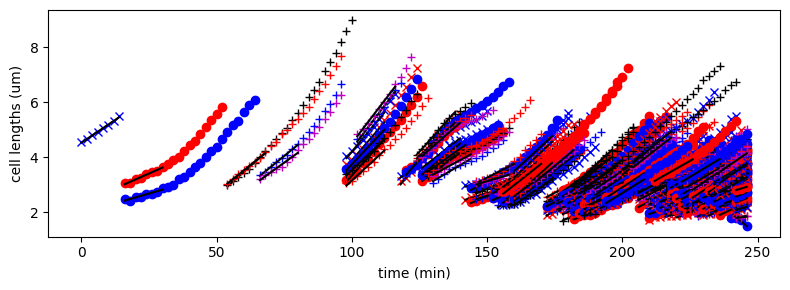

In [19]:
"""Batch elongation rate (fresh) calculation
Fit linear
Input: traj.pkl, elongation-fitted-e.txt
    Calculate fresh elongation rate from linear fitting of first 5 to 8 points (10-16min) after division
    Read in generation from "elongation-fitted-e.txt", G0 at the start of experiment, then G1/2/3...
Output: 
    A plot with cell length to real time, with fitting
    # trajIdx, 1L_b[um], 2elgRateFresh [um/min], 3#G(g0), 4stTime[min]\n'
    # trajIdx, 1L_b[um], 2elgRate [um/min], 3#G(g0), 4stTime[min], 5endTime[min], 6L_d[um], 7elgRateFresh [um/min]\n')


"""
import scipy.optimize
from scipy.optimize import curve_fit

def ef(t, x0, k):
    return x0*np.exp(k*t)

def ef_e(t, x0_e, k):
    return x0_e + k*t

scale60 = 0.1078 # old 0.1083  # um per pixel
# scale100 = 0.065 # old scale 
scale100 = 0.0639  # new scale ab 2405
minpf = 2  # min per frame, 0.5 or 2

# exppath = 'LB-glass-coverslip/240216-glass-GF-ana/T2/'
# exppath = 'LB-glass-coverslip/240221-glass-GF-ana/T3/'
# exppath = 'LB-glass-coverslip/240229-glass-GF-ana/'
# exppath = 'glass-LBLMagar/Elongations/231006-60x/'  #  240228 240307  231006-60x  sorted by biological replicas


# exppath = 'glass-LBLMagar-003/240620-003LBLMagar-ana/'  #240529, 240530, 240612, 240619, 240620
# exppath = 'glass-LBLMagar-0075/240618-0075LBLMagar-ana/'  # 240530, 240613, 240618
# exppath = 'glass-LBLMagar-010/240613-010LBLMagar-ana/' # 240613, 240618
# exppath = 'glass-LBLMagar-015/240228-agar-GF-ana/'  #240228 240307
# exppath = 'LB-glass-coverslip/240229-glass-GF-ana/'
# exppath = 'glass-LBLMagar/Elongations/240307/'  #   240307 231006-60x

rplcpathList = ['glass-LBLMagar-015/240307-agar-GF-ana/00392-3']

# rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir()]  #rplc for replica
ms = ['bx', 'ro', 'bo', 'k+', 'r+', 'b+', 'm+', 'rx']

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath) 
    print(rplcIdx)

    dataDicName = rplcIdx + '-dataDic.pkl'
    plotName = rplcIdx + '-elongation-fresh-l.png'
#     divName = rplcIdx + '-Div.txt'
    trajDicName = rplcIdx + '-trajDic.pkl'
    cnpath = os.path.join(rplcpath, dataDicName)
    plotpath = os.path.join(rplcpath, plotName)
    trajpath = os.path.join(rplcpath, trajDicName)
#     divpath =  os.path.join(rplcpath, divName)
    elgFpath = os.path.join(rplcpath, 'elongation-fresh-l.txt')
   
    with open(cnpath, 'rb') as ff:
        dataDic = pickle.load(ff)    
    with open(trajpath, 'rb') as f:
        trajDic = pickle.load(f)
    elg = np.loadtxt(os.path.join(rplcpath, 'elongation-fitted-e.txt'))
    # trajIdx, 1L_b[um], 2elgRate [um/min], 3#G(g0), 4stTime[min]
    
# cell elongation plot with fitting
    fig, ax = plt.subplots(figsize=[8, 3])
    ax.set_xlabel('time (min)')
    ax.set_ylabel('cell lengths (um)')
    
    elg_f = elg[:, :5]  # take over data from elongation exp fitting, only change elgRate to elgRate_fresh
    # trajIdx, 1L_b[um], 2elgRate_fresh [um/min], 3#G(g0), 4stTime[min]
    
    for i in range(elg.shape[0]):
        trajIdx = str(int(elg[i, 0]))
        traj = trajDic[trajIdx]
        # 0fIdx, 1cellIdx, 2cntx, 3cnty, 4rect0, 5rect1, 6area, 7aspect ratio(AR), 8length, 9angle
        time = traj[:-1, 0] *minpf  # 2 min per frame
        length = traj[:-1, 8] *scale100  # um
        ax.plot(time, length, ms[i%8], label=str(i))
        time_F = time if time.shape[0]<=8 else time[:8]  # use up to 8 frames for fitting
        length_F = length if length.shape[0]<=8 else length[:8] 
        # reset time to 0 for fitting
        time0 = time_F-time[0]
        popt, pcov = curve_fit(ef_e, time0, length_F, p0=[1,0.02]) # fit traj up to 8
        x0_p, k_p = popt
        length_f = ef_e(time0, x0_p, k_p) 
        ax.plot(time_F, length_f, 'k-')
        elg_f[i, 2] = k_p 

#     ax.legend(loc=0, markerscale=0.6, fontsize='xx-small')    
    plt.tight_layout()
    # plt.show()
    plt.savefig(plotpath, dpi=300)     

    np.savetxt(elgFpath, elg_f, fmt='%.4f', header='# trajIdx, 1L_b[um], 2elgRateFresh [um/min], 3#G(g0), 4stTime[min]')

In [24]:
#TODO: unwanted traj end, need to be fixed
print(trajDic['0'][-5:, :])
print(trajDic['1'][:5, :])
print(trajDic['2'][:5, :])

[[   4.       0.     355.46   344.064   18.      79.    1155.       4.389
    79.      90.   ]
 [   5.       0.     355.429  344.807   18.      81.    1192.5      4.5
    81.      90.   ]
 [   6.       0.     355.236  343.949   18.      83.    1214.       4.611
    83.      90.   ]
 [   7.       0.     354.575  343.889   18.      86.    1270.       4.778
    86.      90.   ]
 [   8.       0.     334.034  343.805   18.      48.     729.       2.667
    48.      90.   ]]
[[  8.      0.    334.034 343.805  18.     48.    729.      2.667  48.
   90.   ]
 [  9.      0.    332.863 343.858  18.     48.    744.      2.667  48.
   90.   ]
 [ 10.      1.    332.312 344.38   19.     50.    776.      2.632  50.
   90.   ]
 [ 11.      1.    331.667 344.199  19.     51.    812.      2.684  51.
   90.   ]
 [ 12.      1.    330.809 344.449  19.     53.    840.      2.789  53.
   90.   ]]
[[  8.      1.    379.19  343.371  18.     39.    574.      2.167  39.
   90.   ]
 [  9.      1.    379.562 343.417

In [27]:
"""Batch elongation rate (realtime) calculation
Fit linear, rescale to current length
Input: trajDic.pkl, elongation-fitted-e.txt
    Calculate realtime elongation rate from linear fitting of frame #-4 to #0 (total 5)
    Read in generation from "elongation-fitted-e.txt", G0 at the start of experiment, then G1/2/3...
Output: 
    elgDic
    TrajIdx: # fIdx, cellIdx, cntx, cnty, length, elgRateRT [um/min], elgRateN, #G(g0)\n

"""
import scipy.optimize
from scipy.optimize import curve_fit

def ef_e(t, x0_e, k):
    return x0_e + k*t

scale60 = 0.1078 # old 0.1083  # um per pixel
# scale100 = 0.065 # old scale 
scale100 = 0.0639  # new scale ab 2405
minpf = 2  # min per frame, 0.5 or 2

# exppath = 'glass-LBLMagar-003/240620-003LBLMagar-ana/'  #240529, 240530, 240612, 240619, 240620
# exppath = 'glass-LBLMagar-0075/240618-0075LBLMagar-ana/'  # 240530, 240613, 240618
# exppath = 'glass-LBLMagar-010/240613-010LBLMagar-ana/' # 240613, 240618
# exppath = 'glass-LBLMagar-015/240228-agar-GF-ana/'  #240228 240307
# exppath = 'LB-glass-coverslip/240229-glass-GF-ana/'
# exppath = 'glass-LBLMagar/Elongations/240307/'  #   240307 231006-60x

rplcpathList = ['glass-LBLMagar-015/240307-agar-GF-ana/00392-3']

# rplcpathList = [f.path for f in os.scandir(exppath) if f.is_dir()]  #rplc for replica
ms = ['bx', 'ro', 'bo', 'k+', 'r+', 'b+', 'm+', 'rx']

for rplcpath in sorted(rplcpathList):
    head, rplcIdx = os.path.split(rplcpath) 
    print(rplcIdx)

    dataDicName = rplcIdx + '-dataDic.pkl'
    trajDicName = rplcIdx + '-trajDic.pkl'
    elgDicName = rplcIdx + '-elgRTDic.pkl'
    cnpath = os.path.join(rplcpath, dataDicName)
    trajpath = os.path.join(rplcpath, trajDicName)
    elgpath = os.path.join(rplcpath, elgDicName)
   
    with open(cnpath, 'rb') as ff:
        dataDic = pickle.load(ff)    
    with open(trajpath, 'rb') as f:
        trajDic = pickle.load(f)
    elg = np.loadtxt(os.path.join(rplcpath, 'elongation-fitted-e.txt'))
    # trajIdx, 1L_b[um], 2elgRate [um/min], 3#G(g0), 4stTime[min]
    
    elgDic = {}
    for i in range(elg.shape[0]):
        trajIdx = str(int(elg[i, 0]))
        traj = trajDic[trajIdx]  # 0fIdx, 1cellIdx, 2cntx, 3cnty, 4rect0, 5rect1, 6area, 7aspect ratio(AR), 8length, 9angle
        if traj.shape[0] >= 6:
            elgRT = traj[:, :7].copy()  # 0fIdx, 1cellIdx, 2cntx, 3cnty, 4length [um], 5#G, 6elgRate [/min]
            elgRT[:, 4] = traj[:, 8] *scale100  #length in um
            elgRT[:, 5] = elg[i, 3]
            elgRT[:, 6] = 0
            time = traj[:, 0] *minpf  # 2 min per frame
            time0 = time-time[0]       
            for j in range(elgRT.shape[0]-6):
                popt, pcov = curve_fit(ef_e, time0[j:j+5], elgRT[j:j+5, 4], p0=[1,0.02]) # fit traj [j:j+5] for elg at j+5
                x0_p, k_p = popt
                elgRT[j+5, 6] = k_p/elgRT[j, 4] # rescaled to length at j
    
            elgDic[trajIdx] = elgRT
        
    with open(elgpath, 'wb') as fe:
        pickle.dump(elgDic, fe)
    fe.close()
    f.close()
    ff.close()

00392-3


In [3]:
traj = np.random.rand(4, 3)
traj_F = traj if traj.shape[0]<=8 else traj[:8, :]
print(traj_F)


[[0.769 0.358 0.86 ]
 [0.194 0.845 0.025]
 [0.883 0.125 0.472]
 [0.255 0.65  0.346]]
